In [3]:
import pandas as pd
import warnings

# 嘗試不同編碼讀取，遇到格式錯誤自動跳過異常行
def read_csv_auto(path):
    for enc in ["utf-8-sig", "utf-8", "cp950", "big5", "latin-1"]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                df = pd.read_csv(path, encoding=enc, on_bad_lines='skip')
            print(f"成功讀取，使用編碼: {enc}")
            return df, enc
        except Exception as e:
            print(f"嘗試 {enc} 失敗: {e}")
    raise ValueError("無法讀取 CSV，請確認檔案編碼")

# SNP 對應表
SNP_MAP = {
    "BDNFgene": {2: 0, 8: 1, 7: 2},
    "GNB3":     {2: 0, 1: 1, 3: 2},
    "HTR2A":    {4: 0, 5: 1, 6: 2},
    "HTR1A":    {6: 0, 2: 1, 8: 2},
    "IL1B":     {4: 0, 6: 1, 5: 2},
    "TPH1":     {7: 0, 6: 1, 3: 2},
    "SLC6A4":   {4: 0, 5: 1, 6: 2},
    "OXTR":     {0: 0, 1: 1, 2: 2},
}

# 讀取資料
df, used_enc = read_csv_auto("20210115for ML analysis demorgraphic_remission補平均.csv")
print(f"資料行數: {len(df)}")

# 轉換 SNP
for col, mapping in SNP_MAP.items():
    if col in df.columns:
        df[col + "_raw"] = df[col]
        df[col] = df[col].map(mapping)

# 輸出結果
df.to_csv("converted_snps.csv", index=False, encoding="utf-8-sig")
print("轉換完成，輸出檔案：converted_snps.csv")

嘗試 utf-8-sig 失敗: 'utf-8' codec can't decode bytes in position 15-16: invalid continuation byte
嘗試 utf-8 失敗: 'utf-8' codec can't decode bytes in position 0-1: invalid continuation byte
嘗試 cp950 失敗: 'cp950' codec can't decode byte 0xee in position 15: illegal multibyte sequence
嘗試 big5 失敗: 'big5' codec can't decode byte 0xee in position 15: illegal multibyte sequence
成功讀取，使用編碼: latin-1
資料行數: 200
轉換完成，輸出檔案：converted_snps.csv


Columns: ['res_no_1', 'age', 'sex', 'BH', 'BW', 'BMI', 'SBP', 'DBP', 'ACsugar_LOCF', 'Insulin_LOCF', 'HbA1c_LOCF', 'Cpeptide_LOCF', 'HOMAIR_LOCF', 'HOMAb_LOCF', 'd1_corti_LOCF', 'leptin_3_LOCF', 'Chol_LOCF', 'TG_LOCF', 'HDL_LOCF', 'LDL_LOCF', 'LDL_HDL_LOCF', 'oxytocin_LOCF', 'hsCRP_LOCF', 'HAMD_V1_LOCF', 'HAMD_V4_LOCF', 'whoqol28_ov', 'whoqol28_ph', 'whoqol28_ps', 'whoqol28_sr', 'whoqol28_en', 'whoqol28_s', 'SSS.ia_s', 'SSS.ib_s', 'SSS.iia_s', 'SSS.iib_s', 'sss_sum', 'les_e_s', 'responderv41_LOCF', 'remissionv41_LOCF', 'edu_year', 'Drug', 'BDNFgene', 'BDNFgene.1', 'GNB3', 'GNB3.1', 'HTR2A', 'HTR2A.1', 'HTR1A', 'HTR1A.1', 'IL1B', 'IL1B.1', 'TPH1', 'TPH1.1', 'SLC6A4', 'SLC6A4.1', 'OXTR', 'OXTR.1', 'ftt_r_LOCF', 'ftt_l_LOCF', 'pers_err_LOCF', 'cacmplt_LOCF', 'd_a_LOCF', 'd_b_LOCF', 'BDNFgene_raw', 'GNB3_raw', 'HTR2A_raw', 'HTR1A_raw', 'IL1B_raw', 'TPH1_raw', 'SLC6A4_raw', 'OXTR_raw']
Targets: ['responderv41_LOCF', 'remissionv41_LOCF']
Initial feature count: 69
Dropped ID-like columns: ['r

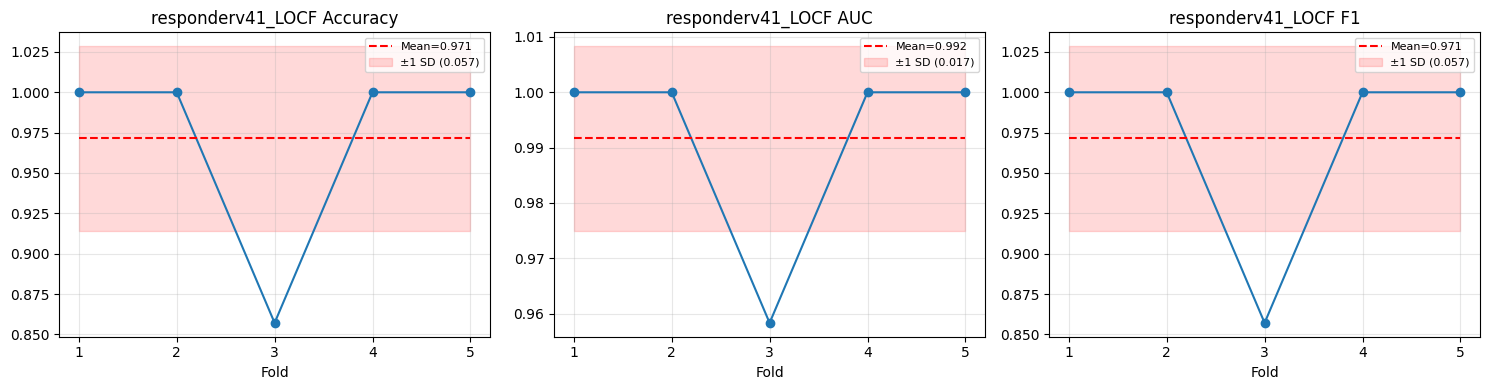

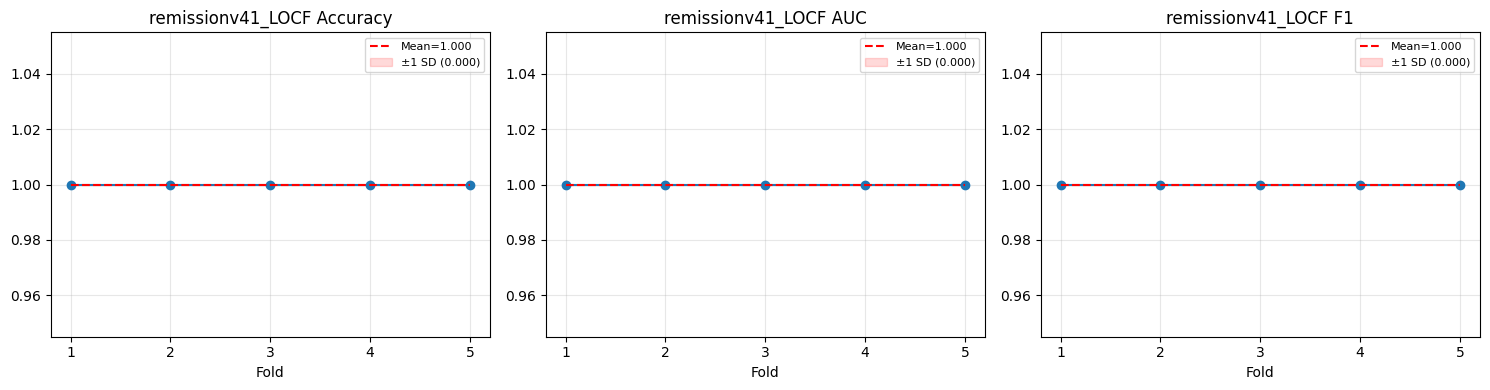


Drug-related columns detected: ['Drug']

[Drug-only] Target: responderv41_LOCF
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.683564
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.683529
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.683564
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.683251
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.662359
Drug-only CV Accuracy: 0.5857 ± 0.0286

[Drug-only] Target: remissionv41_LOCF
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.651242
Training until validation scor

In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re

# 讀取資料
df = pd.read_csv("converted_snps.csv", encoding="utf-8-sig")
print("Columns:", df.columns.tolist())

# ---- 檢查並處理可能重複的 target 欄位 (例如 remissionv41_LOCF 與 remissionv41_LOCF.1) ----
base_target_candidates = ["responderv41_LOCF", "remissionv41_LOCF"]
from collections import defaultdict
actual_target_groups = defaultdict(list)
for col in df.columns:
    for base in base_target_candidates:
        if col == base or re.fullmatch(fr"{base}\.\d+", col):
            actual_target_groups[base].append(col)

targets_dropped = []
for base, cols in actual_target_groups.items():
    if len(cols) > 1:
        first_series = df[cols[0]]
        all_equal = all(df[c].equals(first_series) for c in cols[1:])
        if all_equal:
            dup_to_drop = cols[1:]
            df.drop(columns=dup_to_drop, inplace=True)
            targets_dropped.extend(dup_to_drop)
            print(f"Duplicate identical target columns detected for {base}: dropped {dup_to_drop}")
        else:
            print(f"Warning: Multiple non-identical versions of target {base} found: {cols}. Keeping all; please inspect.")

# 目標欄位
target_cols = [c for c in base_target_candidates if c in df.columns]
target_cols = list(dict.fromkeys(target_cols))
if not target_cols:
    raise ValueError("找不到 responderv41_LOCF 或 remissionv41_LOCF 目標欄位")
print("Targets:", target_cols)

# 預設基因 SNP 及類別特徵候選
gene_candidates = ["BDNFgene","GNB3","HTR2A","HTR1A","IL1B","TPH1","SLC6A4","OXTR"]
cat_feature_names = []
if "sex" in df.columns:
    cat_feature_names.append("sex")
for g in gene_candidates:
    if g in df.columns:
        cat_feature_names.append(g)

# 去除目標欄位得到特徵
feature_df = df.drop(columns=target_cols, errors='ignore')
print(f"Initial feature count: {feature_df.shape[1]}")

# ---- 辨識 ID / 非數值字串欄位 ----
object_cols = [c for c in feature_df.columns if feature_df[c].dtype == 'object']
id_like_cols = []
low_card_candidate_cat = []
dropped_as_id = []
for c in object_cols:
    col_series = feature_df[c].astype(str)
    nunq = col_series.nunique(dropna=True)
    total = len(col_series)
    if nunq == total or nunq / total > 0.9 or col_series.str.match(r'^[A-Za-z]*\d+$').all():
        id_like_cols.append(c)
        continue
    if nunq <= 15:
        low_card_candidate_cat.append(c)
    else:
        id_like_cols.append(c)

if id_like_cols:
    feature_df = feature_df.drop(columns=id_like_cols)
    dropped_as_id = id_like_cols[:]
    print("Dropped ID-like columns:", dropped_as_id)
else:
    print("No ID-like columns dropped.")

# 更新類別特徵列表 (加入低基數字串)
for c in low_card_candidate_cat:
    if c not in cat_feature_names and c in feature_df.columns:
        cat_feature_names.append(c)

# 分出類別與數值欄位
cat_feature_names = [c for c in cat_feature_names if c in feature_df.columns]
numeric_cols = []
for c in feature_df.columns:
    if c in cat_feature_names:
        continue
    if pd.api.types.is_numeric_dtype(feature_df[c]):
        numeric_cols.append(c)
    else:
        converted = pd.to_numeric(feature_df[c], errors='coerce')
        if converted.notna().sum() / len(converted) > 0.95:
            feature_df[c] = converted
            numeric_cols.append(c)
        else:
            nunq = feature_df[c].nunique()
            if nunq <= 15:
                feature_df[c] = feature_df[c].astype('category')
                cat_feature_names.append(c)
            else:
                feature_df = feature_df.drop(columns=[c])
                print(f"Dropped high-card non-numeric column: {c}")

print(f"Categorical features: {cat_feature_names}")
print(f"Numeric features: {len(numeric_cols)} columns")

# 類別轉 dtype=category
for c in cat_feature_names:
    feature_df[c] = feature_df[c].astype('category')

# Z-score 正規化數值欄位
scaler = StandardScaler()
if numeric_cols:
    feature_df[numeric_cols] = scaler.fit_transform(feature_df[numeric_cols])

# 交叉驗證設定
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=2025)

# LightGBM 參數
base_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 2025,
    'max_depth': 3,
    'num_leaves': 3,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'learning_rate': 0.08,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0
}

def run_cv(target_name):
    y = df[target_name]
    X = feature_df.copy()
    fold_acc = []
    fold_logloss = []
    fold_auc = []
    fold_f1 = []
    feature_importance_accum = pd.Series(0.0, index=X.columns, dtype=float)
    cat_idx = [X.columns.get_loc(c) for c in cat_feature_names] if cat_feature_names else []
    for fold,(train_idx,val_idx) in enumerate(skf.split(X,y),1):
        X_train,X_val = X.iloc[train_idx],X.iloc[val_idx]
        y_train,y_val = y.iloc[train_idx],y.iloc[val_idx]
        lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_idx if cat_idx else None, free_raw_data=False)
        lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=cat_idx if cat_idx else None, free_raw_data=False)
        model = lgb.train(base_params, lgb_train, valid_sets=[lgb_val], num_boost_round=300, callbacks=[lgb.early_stopping(stopping_rounds=25)])
        preds_prob = model.predict(X_val, num_iteration=model.best_iteration)
        preds = (preds_prob > 0.5).astype(int)
        acc = accuracy_score(y_val, preds)
        ll = log_loss(y_val, preds_prob)
        try:
            auc = roc_auc_score(y_val, preds_prob)
        except ValueError:
            auc = np.nan  # 單一類別情況
        f1 = f1_score(y_val, preds, zero_division=0)
        fold_acc.append(acc)
        fold_logloss.append(ll)
        fold_auc.append(auc)
        fold_f1.append(f1)
        fi = pd.Series(model.feature_importance(importance_type='gain'), index=X.columns)
        feature_importance_accum = feature_importance_accum.add(fi, fill_value=0)
        print(f"Fold {fold}: ACC={acc:.4f} AUC={auc if not np.isnan(auc) else 'nan'} F1={f1:.4f} LogLoss={ll:.4f} BestIter={model.best_iteration}")
    print(f"\n[{target_name}] CV Accuracy: {np.mean(fold_acc):.4f} ± {np.std(fold_acc):.4f}")
    print(f"[{target_name}] CV AUC:      {np.nanmean(fold_auc):.4f} ± {np.nanstd(fold_auc):.4f}")
    print(f"[{target_name}] CV F1:       {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")
    print(f"[{target_name}] CV LogLoss:  {np.mean(fold_logloss):.4f} ± {np.std(fold_logloss):.4f}")
    fi_mean = (feature_importance_accum / FOLDS).sort_values(ascending=False)
    print(f"\n[{target_name}] Top 10 Feature Importance:")
    for i,(feat,val) in enumerate(fi_mean.head(10).items(),1):
        print(f"{i:2d}. {feat}: {val:.2f}")
    metrics = {
        'acc': fold_acc,
        'auc': fold_auc,
        'f1': fold_f1,
        'logloss': fold_logloss
    }
    return fi_mean, metrics

all_fi = {}
all_metrics = {}
for t in target_cols:
    print("\n==============================")
    print(f"CV for target: {t}")
    fi, m = run_cv(t)
    all_fi[t] = fi
    all_metrics[t] = m

# ---- 繪圖：每個 target 的 Accuracy, AUC, F1 (fold-level) ----
for t in target_cols:
    m = all_metrics[t]
    folds = np.arange(1, len(m['acc'])+1)
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    # Helper function
    def plot_metric(ax, values, title):
        vals = np.array(values, dtype=float)
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        ax.plot(folds, vals, marker='o', linestyle='-')
        ax.hlines(mean, folds[0], folds[-1], colors='red', linestyles='--', label=f"Mean={mean:.3f}")
        ax.fill_between(folds, mean-std, mean+std, color='red', alpha=0.15, label=f"±1 SD ({std:.3f})")
        ax.set_title(f"{t} {title}")
        ax.set_xlabel('Fold')
        ax.set_xticks(folds)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8)
    plot_metric(axes[0], m['acc'], 'Accuracy')
    plot_metric(axes[1], m['auc'], 'AUC')
    plot_metric(axes[2], m['f1'], 'F1')
    plt.tight_layout()
    plt.show()

# (保留 drug-only 區塊，但不繪圖)
drug_cols = [c for c in feature_df.columns if 'drug' in c.lower()]
if drug_cols:
    print("\nDrug-related columns detected:", drug_cols)
    for t in target_cols:
        print(f"\n[Drug-only] Target: {t}")
        y = df[t]
        X_drug = feature_df[drug_cols].copy()
        for c in drug_cols:
            if X_drug[c].dtype.kind in 'if' and X_drug[c].nunique() <= 10:
                X_drug[c] = X_drug[c].astype('category')
        cat_idx_drug = [X_drug.columns.get_loc(c) for c in drug_cols if str(X_drug[c].dtype)=="category"]
        fold_acc = []
        for fold,(train_idx,val_idx) in enumerate(skf.split(X_drug,y),1):
            X_train,X_val = X_drug.iloc[train_idx],X_drug.iloc[val_idx]
            y_train,y_val = y.iloc[train_idx],y.iloc[val_idx]
            lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_idx_drug if cat_idx_drug else None, free_raw_data=False)
            lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=cat_idx_drug if cat_idx_drug else None, free_raw_data=False)
            model = lgb.train(base_params, lgb_train, valid_sets=[lgb_val], num_boost_round=200, callbacks=[lgb.early_stopping(stopping_rounds=20)])
            preds = (model.predict(X_val, num_iteration=model.best_iteration) > 0.5).astype(int)
            fold_acc.append(accuracy_score(y_val, preds))
        print(f"Drug-only CV Accuracy: {np.mean(fold_acc):.4f} ± {np.std(fold_acc):.4f}")
else:
    print("\nNo drug-related columns detected (name containing 'drug'). 若有特定欄位名稱請告知。")